# k-means clustering

2,3차원으로 하니까 값이 제대로 나오지 않아서
31차원으로 한 다음에 차원축소를 통해 보려고 한다.

---

## 0. import libraries

In [11]:
from sklearn import datasets
import pandas as pd
import json
import re # regular expression
import gc # to collect memory
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [12]:
# load json files
with open("./res/genre_gn_all.json", encoding = 'utf-8') as json_file: genre_gn_all = json.load(json_file)
#with open("./res/song_meta.json", encoding = 'utf-8') as json_file: song_meta = json.load(json_file)
#with open("./res/train.json", encoding = 'utf-8') as json_file: train = json.load(json_file)
with open("./res/val.json", encoding = 'utf-8') as json_file: valid = json.load(json_file)

# json to dataframe
genre_gn_all = pd.Series(genre_gn_all).to_frame('genre').reset_index().rename({'index' : 'gen_id'}, axis = 1)
song_meta = pd.read_json('./res/song_meta_cnt.json', orient='table')
train = pd.read_json('./res/train_topgnr.json', orient='table')
valid = pd.DataFrame(valid)
tag_cnt=pd.read_json('./res/tag_cnt.json', orient='table')

In [13]:
genre_gn_all

,gen_id,genre
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
...,...,...
249,GN2900,뮤지컬
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬
252,GN2903,국외뮤지컬


In [14]:
#대분류장르코드
# 장르코드 뒷자리 두 자리가 00인 코드를 필터링
gnr_code = genre_gn_all[genre_gn_all['gen_id'].str[-2:] == '00']
gnr_code

,gen_id,genre
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


In [15]:
train

,tags,id,plylst_title,songs,like_cnt,updt_date,most_appearing_gnr
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,GN0900
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,GN0100
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,GN0400
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,GN0100
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,GN0200
...,...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,GN1000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,GN1100
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,GN0100
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,GN1000


In [16]:
tag_cnt

,tags,mapping_cnt
0,,1
1,00,4
2,007,3
3,007시리즈,2
4,00s,3
...,...,...
29155,힙해,5
29156,힙힙힙,2
29157,힛뎀포크,1
29158,힛뎀폭,1


# 1. 목표 설정

### train에 most_appearing_gnr(대분류 장르)를 기준으로 많이 나오는 태그를 묶는다.

# 2. train에 장르 등장 열 추가

In [17]:
# train 복사본
train_gnrmap=train
train_gnrmap

,tags,id,plylst_title,songs,like_cnt,updt_date,most_appearing_gnr
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,GN0900
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,GN0100
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,GN0400
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,GN0100
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,GN0200
...,...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,GN1000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,GN1100
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,GN0100
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,GN1000


In [18]:
# 대분류 장르
gnr_code

,gen_id,genre
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


In [19]:
#편의를 위하여 대분류 장르의 index 초기화

## 복사
gnr_code_ind=gnr_code
gnr_code_ind

## index reset하겠음(문자 단위 검색 목적이므로)
gnr_code_ind=gnr_code_ind.reset_index()
del gnr_code_ind['index']

gnr_code_ind

,gen_id,genre
0,GN0100,발라드
1,GN0200,댄스
2,GN0300,랩/힙합
3,GN0400,R&B/Soul
4,GN0500,인디음악
5,GN0600,록/메탈
6,GN0700,성인가요
7,GN0800,포크/블루스
8,GN0900,POP
9,GN1000,록/메탈


In [20]:
#boolean 배열 test
train_gnrmap['most_appearing_gnr']==gnr_code_ind['gen_id'][2]
#train_gnrmap[train_gnrmap['most_appearing_gnr']==gnr_code['gen_id'][0]]

0         False
1         False
2         False
3         False
4         False
          ...  
115066    False
115067    False
115068    False
115069    False
115070    False
Name: most_appearing_gnr, Length: 115071, dtype: bool

In [21]:
# 열을 만들기 위한 문자열 출력 test
for i in range(0,15):
    test_str=i
    test_str=str(i)
    if i<10:
        print('GN0'+test_str+'00')
    else:
        print('GN'+test_str+'00')

GN0000
GN0100
GN0200
GN0300
GN0400
GN0500
GN0600
GN0700
GN0800
GN0900
GN1000
GN1100
GN1200
GN1300
GN1400


In [22]:
# 추가하기
for i in range(1,31):
    test_str=i
    test_str=str(i)
    if i<10:
        test_str='GN0'+test_str+'00'
        print(test_str)
    else:
        test_str='GN'+test_str+'00'
        print(test_str)
    
    #most_appearing_gnr 기준으로 했음에 유의!
    train_gnrmap[test_str]=train_gnrmap['most_appearing_gnr']==gnr_code_ind['gen_id'][i-1]

GN0100
GN0200
GN0300
GN0400
GN0500
GN0600
GN0700
GN0800
GN0900
GN1000
GN1100
GN1200
GN1300
GN1400
GN1500
GN1600
GN1700
GN1800
GN1900
GN2000
GN2100
GN2200
GN2300
GN2400
GN2500
GN2600
GN2700
GN2800
GN2900
GN3000


In [23]:
train_gnrmap

,tags,id,plylst_title,songs,like_cnt,updt_date,most_appearing_gnr,GN0100,GN0200,GN0300,...,GN2100,GN2200,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,GN0900,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,GN0100,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,GN0400,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,GN0100,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,GN0200,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,GN1000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,GN1100,False,False,False,...,False,False,False,False,False,False,False,False,False,False
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,GN0100,True,False,False,...,False,False,False,False,False,False,False,False,False,False
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,GN1000,False,False,False,...,False,False,False,False,False,False,False,False,False,False


---

# 3. tag에 장르 열 넣기

In [26]:
#불러오기
train_gnrmap=pd.read_json('./res/train_gnrmap_ntag.json', orient='table')
train_gnrmap

,tags,id,plylst_title,songs,like_cnt,updt_date,most_appearing_gnr,GN0100,GN0200,GN0300,...,GN2200,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,tag_len
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,GN0900,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,GN0100,True,False,False,...,False,False,False,False,False,False,False,False,False,2
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,GN0400,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,GN0100,True,False,False,...,False,False,False,False,False,False,False,False,False,10
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,GN0200,False,True,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,GN1000,False,False,False,...,False,False,False,False,False,False,False,False,False,7
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,GN1100,False,False,False,...,False,False,False,False,False,False,False,False,False,1
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,GN0100,True,False,False,...,False,False,False,False,False,False,False,False,False,8
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,GN1000,False,False,False,...,False,False,False,False,False,False,False,False,False,6


In [27]:
tag_cnt_gnrmap=tag_cnt
tag_cnt_gnrmap

,tags,mapping_cnt
0,,1
1,00,4
2,007,3
3,007시리즈,2
4,00s,3
...,...,...
29155,힙해,5
29156,힙힙힙,2
29157,힛뎀포크,1
29158,힛뎀폭,1


In [28]:
# 빈 열 만들기
for i in range(1,31):
    test_str=i
    test_str=str(i)
    if i<10:
        test_str='GN0'+test_str+'00'
        print(test_str)
    else:
        test_str='GN'+test_str+'00'
        print(test_str)
    tag_cnt_gnrmap[test_str]=False

GN0100
GN0200
GN0300
GN0400
GN0500
GN0600
GN0700
GN0800
GN0900
GN1000
GN1100
GN1200
GN1300
GN1400
GN1500
GN1600
GN1700
GN1800
GN1900
GN2000
GN2100
GN2200
GN2300
GN2400
GN2500
GN2600
GN2700
GN2800
GN2900
GN3000


In [29]:
#GN9000 추가
tag_cnt_gnrmap['GN9000']=False

In [34]:
tag_cnt_gnrmap.info()
tag_cnt_gnrmap

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29160 entries, 0 to 29159
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tags         29160 non-null  object
 1   mapping_cnt  29160 non-null  int64 
 2   GN0100       29160 non-null  bool  
 3   GN0200       29160 non-null  bool  
 4   GN0300       29160 non-null  bool  
 5   GN0400       29160 non-null  bool  
 6   GN0500       29160 non-null  bool  
 7   GN0600       29160 non-null  bool  
 8   GN0700       29160 non-null  bool  
 9   GN0800       29160 non-null  bool  
 10  GN0900       29160 non-null  bool  
 11  GN1000       29160 non-null  bool  
 12  GN1100       29160 non-null  bool  
 13  GN1200       29160 non-null  bool  
 14  GN1300       29160 non-null  bool  
 15  GN1400       29160 non-null  bool  
 16  GN1500       29160 non-null  bool  
 17  GN1600       29160 non-null  bool  
 18  GN1700       29160 non-null  bool  
 19  GN1800       29160 non-nu

,tags,mapping_cnt,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,...,GN2200,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000
0,,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,00,4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,007,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,007시리즈,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,00s,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29155,힙해,5,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29156,힙힙힙,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29157,힛뎀포크,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29158,힛뎀폭,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [35]:
# 태그에 장르 정보들 추가하기
# 3중포문만이 정답일까...? 그리고사실 가장많이 나온 장르로해서 정확도도 잘모르겠다..
import time
start = time.time()

for h in range(0,115071):
    for i in range(0, 29160):
        
        #그나마 속도를 향상시켜줄..
        if tag_cnt_gnrmap['tags'][i] in train_gnrmap['tags'][h]: 
            for j in range(0,train_gnrmap['tag_len'][h]):
                if(train_gnrmap['tags'][h][j]==tag_cnt_gnrmap['tags'][i]):
                    tag_cnt_gnrmap[train_gnrmap['most_appearing_gnr'][h]][i]=tag_cnt_gnrmap[train_gnrmap['most_appearing_gnr'][h]][i] or True

    if(h%10==0):
        print(h)
        print("time :", time.time() - start) 
        print("\n")

print("FINISH TIME!! :", time.time() - start) 

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


0
time : 0.7234275341033936


10
time : 7.973940134048462


20
time : 15.324358701705933


30
time : 22.732588529586792


40
time : 30.310598134994507


50
time : 38.155014753341675


60
time : 46.090407371520996


70
time : 53.82365560531616


80
time : 61.51068830490112


90
time : 69.25768160820007


100
time : 77.27861857414246


110
time : 85.116854429245


120
time : 93.08397579193115


130
time : 101.05724763870239


140
time : 108.97168135643005


150
time : 117.05197048187256


160
time : 125.23427891731262


170
time : 133.47278809547424


180
time : 141.6912658214569


190
time : 149.74432682991028


200
time : 157.6682231426239


210
time : 165.62905073165894


220
time : 173.51308465003967


230
time : 181.74595069885254


240
time : 189.3844611644745


250
time : 197.28728532791138


260
time : 205.1980767250061


270
time : 213.45453262329102


280
time : 221.62831020355225


290
time : 229.90406346321106


300
time : 238.09452366828918


310
time : 245.8220043182373


3

KeyboardInterrupt: 

## 다는 못해보고 일단 코드짜는동안만 되는걸로.. 시도해볼 예정

---
# 4. k-means Clustering

- 목표: 차원이 k-means 01에서는 2개 or 3개였다면 차원을 10개~31개로 해서 clustering을 한 뒤에 차원축소를 통해 분포를 확인할 예정이다.

In [39]:
feature=tag_cnt_gnrmap[['GN0100','GN0200','GN0300','GN0400','GN0500','GN0600','GN0700','GN0800','GN0900','GN1000',
                        'GN1100','GN1200','GN1300','GN1400','GN1500','GN1600','GN1700','GN1800','GN1900','GN2000',
                       'GN2100','GN2200','GN2300','GN2400','GN2500','GN2600','GN2700','GN2800','GN2900','GN3000','GN9000']]
feature

,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,GN0900,GN1000,...,GN2200,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29155,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29156,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29157,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29158,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [40]:
model = KMeans(n_clusters=10,algorithm='auto')
model.fit(feature)
predict = pd.DataFrame(model.predict(feature))
predict.columns=['predict']

In [41]:
r = pd.concat([feature,predict],axis=1)

---
# 5. 차원축소(그래프 확인 목적)

In [42]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [50]:
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

## t-SNE

### 2차원 축소

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(feature)

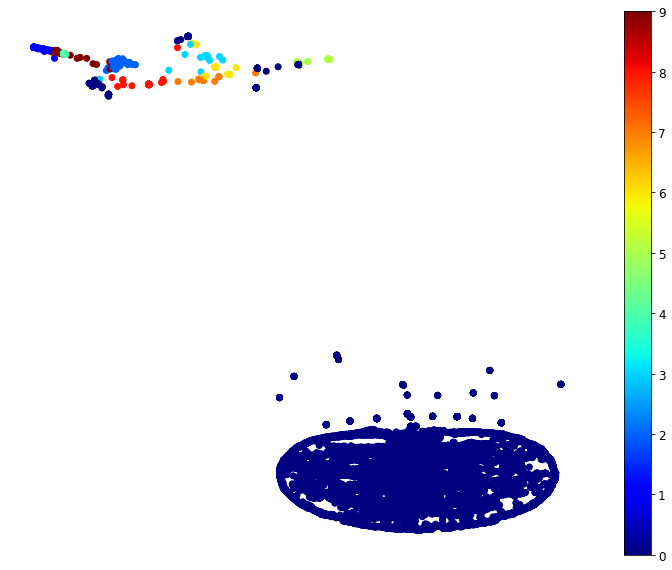

In [53]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0],
            X_reduced[:, 1],
            c=r['predict'],
            cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

저건 대체 뭘까....

### 3차원

In [55]:
tsne3 = TSNE(n_components=3, random_state=42)
X_reduced3 = tsne3.fit_transform(feature)

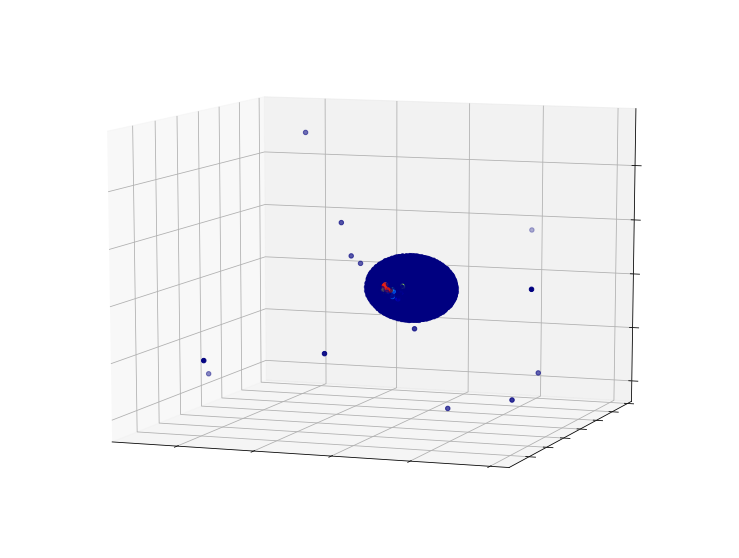

In [57]:
plt.figure(figsize=(13,10))
ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_reduced3[:, 0], X_reduced3[:, 1], X_reduced3[:, 2], c=r['predict'], cmap="jet")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

## PCA
### 2차원

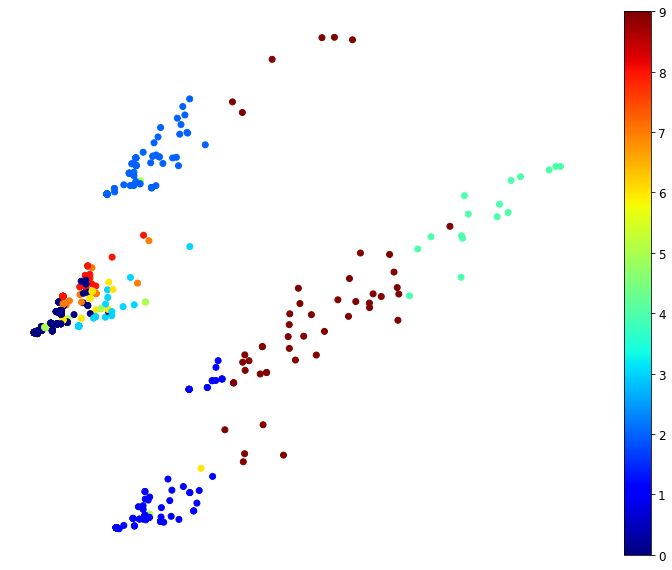

In [48]:
from sklearn.decomposition import PCA
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(feature)
plt.figure(figsize=(13,10))
plt.scatter(X_pca_reduced[:, 0],
            X_pca_reduced[:, 1],
            c=r['predict'],
            cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

### PCA 3차원

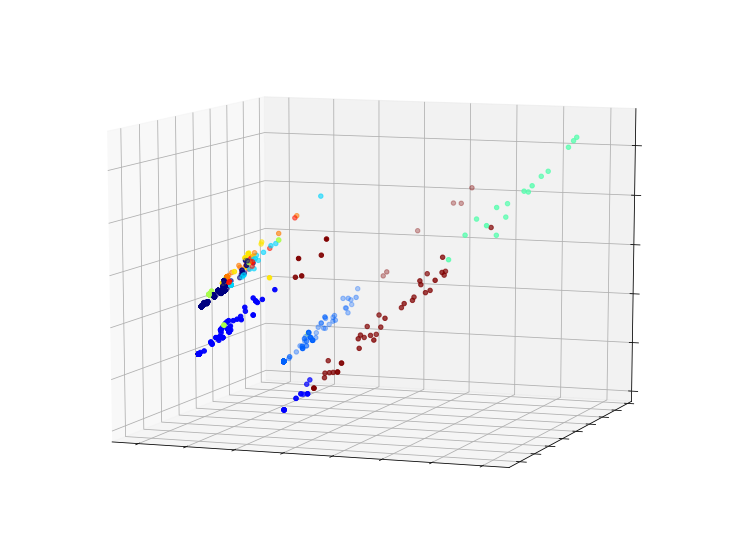

In [51]:
plt.figure(figsize=(13, 10))

X_pca_reduced = PCA(n_components=3, random_state=42).fit_transform(feature)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], X_pca_reduced[:, 2], c=r['predict'], cmap="jet")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

## LLE
### 2차원

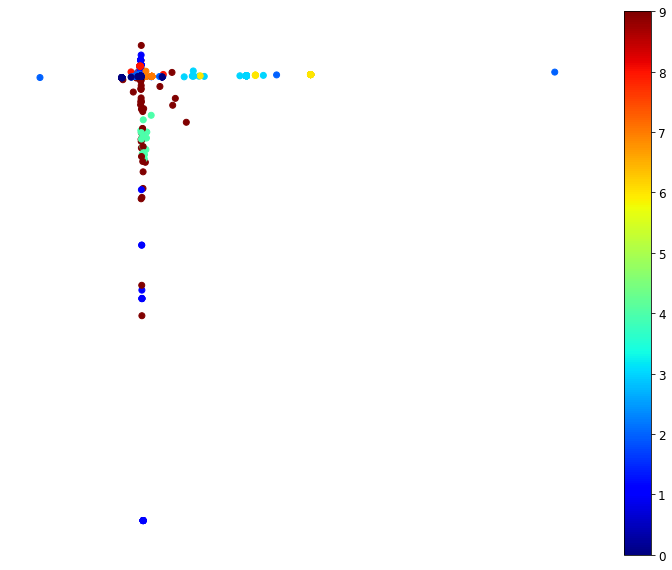

In [58]:
from sklearn.manifold import LocallyLinearEmbedding
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(feature)
plt.figure(figsize=(13,10))
plt.scatter(X_lle_reduced[:, 0],
            X_lle_reduced[:, 1],
            c=r['predict'],
            cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

### 3차원

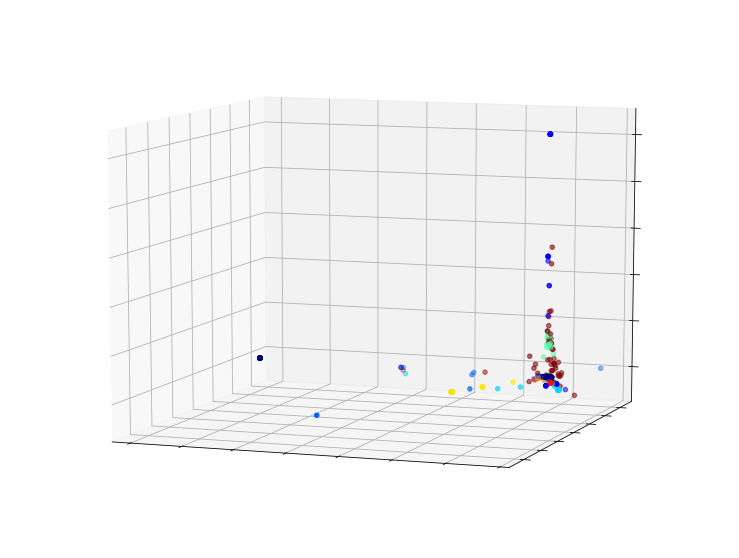

In [59]:
plt.figure(figsize=(13, 10))

X_lle_reduced = LocallyLinearEmbedding(n_components=3, random_state=42).fit_transform(feature)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_lle_reduced[:, 0], X_lle_reduced[:, 1], X_lle_reduced[:, 2], c=r['predict'], cmap="jet")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

## LDA
### 2차원

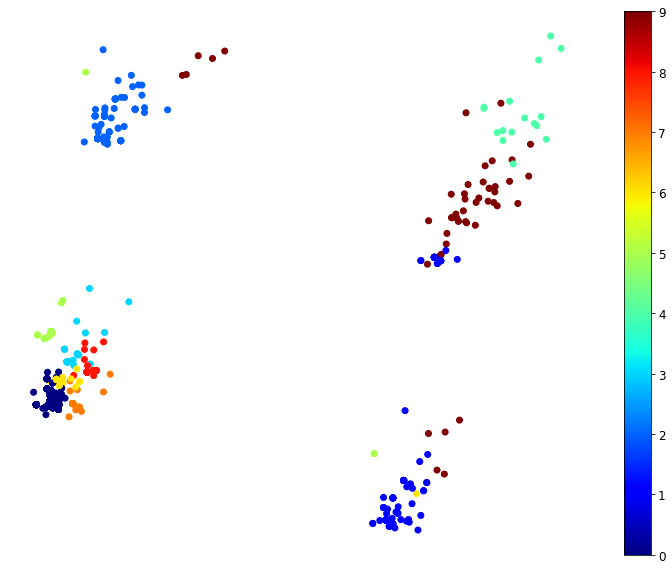

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(feature, r['predict'])
plt.figure(figsize=(13,10))
plt.scatter(X_lda_reduced[:, 0],
            X_lda_reduced[:, 1],
            c=r['predict'],
            cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

### 3차원

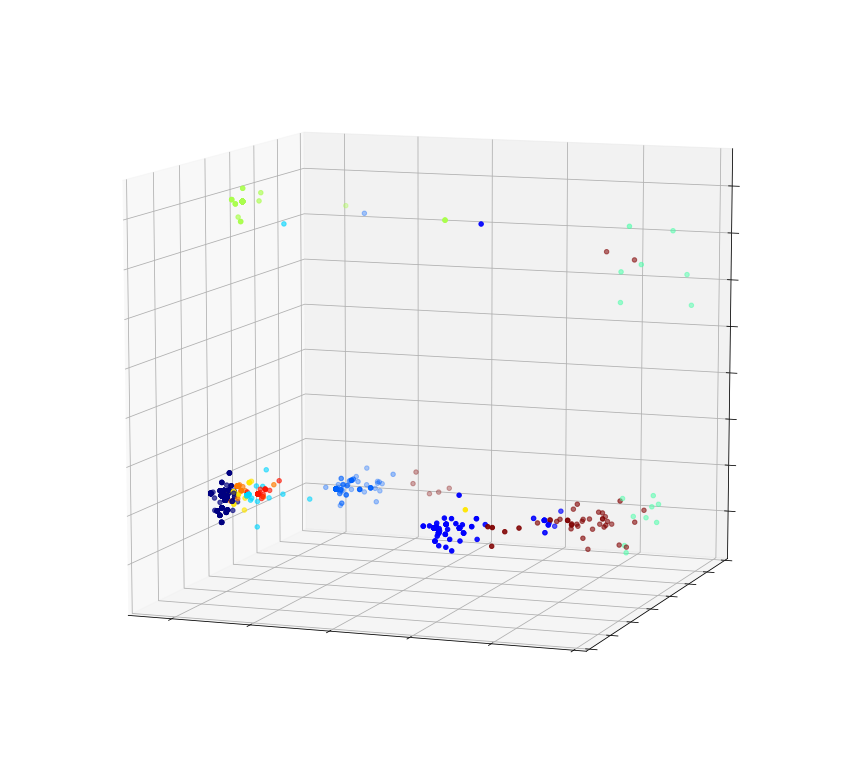

In [61]:
plt.figure(figsize=(15, 14))

X_lda_reduced3 = LinearDiscriminantAnalysis(n_components=3).fit_transform(feature, r['predict'])

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_lda_reduced3[:, 0], X_lda_reduced3[:, 1], X_lda_reduced3[:, 2], c=r['predict'], cmap="jet")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

---
# 6. cluster 목록 확인하기 (100개로 클러스터링)

In [80]:
model2 = KMeans(n_clusters=100,algorithm='auto')
model2.fit(feature)
predict2 = pd.DataFrame(model2.predict(feature))
predict2.columns=['predict']

In [81]:
r = pd.concat([feature,predict2],axis=1)

In [82]:
labels = model2.labels_
centers = model2.cluster_centers_

In [83]:
tag_cnt_gnrmap['labels']=labels

In [100]:
tag_cnt_gnrmap

,tags,mapping_cnt,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,...,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000,labels
0,,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,00,4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,007,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,007시리즈,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,00s,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29155,힙해,5,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29156,힙힙힙,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29157,힛뎀포크,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29158,힛뎀폭,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [102]:
tag_cnt_gnrmap.head(100)

,tags,mapping_cnt,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,...,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000,labels
0,,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,00,4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,007,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,007시리즈,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,00s,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11일,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
96,11화,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
97,12,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
98,1218,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [99]:
tag_cnt_gnrmap.loc[tag_cnt_gnrmap['labels']==37]

,tags,mapping_cnt,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,...,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000,labels
9465,데이트,469,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,37
19178,연말,468,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,37
25157,캐럴,75,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,37
25614,크리스마스송,6,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,37
27364,하늘,100,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,37


In [110]:
tag_cnt_gnrmap.loc[tag_cnt_gnrmap['labels']==0]

,tags,mapping_cnt,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,...,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000,labels
0,,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,00,4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,007,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,007시리즈,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,00s,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29155,힙해,5,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29156,힙힙힙,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29157,힛뎀포크,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29158,힛뎀폭,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


### 0에만 27881개가 몰리는 현상 발생. 물론 10만개중 1000개만 학습시켰지만...
### 그러니 mapping_cnt도 고려한 ver 만들기
---
# 7. mapping_cnt 고려한 cluster 목록 확인하기

In [122]:
tag_cnt_gnrmap2=tag_cnt_gnrmap

In [132]:
feature2=tag_cnt_gnrmap[['mapping_cnt',
                         'GN0100','GN0200','GN0300','GN0400','GN0500','GN0600','GN0700','GN0800','GN0900','GN1000',
                        'GN1100','GN1200','GN1300','GN1400','GN1500','GN1600','GN1700','GN1800','GN1900','GN2000',
                       'GN2100','GN2200','GN2300','GN2400','GN2500','GN2600','GN2700','GN2800','GN2900','GN3000','GN9000'
                        ]]
feature2

,mapping_cnt,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,GN0900,...,GN2200,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000
0,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29155,5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29156,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29157,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29158,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [133]:
model3 = KMeans(n_clusters=100,algorithm='auto')
model3.fit(feature2)
predict3 = pd.DataFrame(model3.predict(feature2))
predict3.columns=['predict']

In [134]:
r2 = pd.concat([feature2,predict3],axis=1)

In [135]:
labels2 = model3.labels_
centers2 = model3.cluster_centers_

In [136]:
tag_cnt_gnrmap2['labels']=labels2

In [137]:
tag_cnt_gnrmap2

,tags,mapping_cnt,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,...,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000,labels
0,,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,54
1,00,4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,95
2,007,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,93
3,007시리즈,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,00s,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29155,힙해,5,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,39
29156,힙힙힙,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29157,힛뎀포크,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,54
29158,힛뎀폭,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,54


In [142]:
tag_cnt_gnrmap2.loc[tag_cnt_gnrmap2['labels']==0]

,tags,mapping_cnt,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,...,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000,labels
3,007시리즈,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
8,00년대발라드,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
21,05,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
23,06,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
24,07,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29138,힙합존,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29144,힙합탑백,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29151,힙합플레이야,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
29156,힙힙힙,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [146]:
tag_cnt_gnrmap2.loc[tag_cnt_gnrmap2['labels']==60]

,tags,mapping_cnt,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,...,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000,GN9000,labels
186,1970_80,86,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60
470,2018,87,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60
871,8090,90,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60
2062,JAYJE,84,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60
2944,SWAG,83,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60
3090,TOP20,86,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60
4370,pub,84,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60
5599,갬성,88,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60
7441,꽃,87,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,60
7521,꿀음색,84,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60


### mapping count가 비슷한것끼리 얼추 묶였으나..! mapping count가 비슷하다고 tag가 비슷하지는 않다!